In [1]:
import numpy as np
import numpy.linalg as LA
import scipy as sp
import scipy.stats as st
import scipy.special as ss

import matplotlib.pyplot as plt

import pandas as pd

In [45]:
class Leaf():
    """Base Class for Leafs/ Roots of all types
    
    Attributes
    ----------
    tree : Tree
        reference to the tree the leaf belongs to
        
    parent : Leaf/Root
        reference to the node one hierarchy level above
        
    tested : bool
        variable used during tree search that tells wether
        everything beneath that tree has been already checked
        True -> step to the other leaf of the parent node   
        
    x : np.array [N, D]
        input data
        
    r : np.array [N, 1]
        residuals
        
    p : np.array [N, 1]
        probability of output (only relevant for Classification)
        
    depth : int
        current level of inside the tree hierarchy
        
    Methods
    -------
    to_root() -> void
        Change Class of object from Leaf-child to Root-child
        
    can_be_split() -> bool
        Decide whether obj of class Leaf-child should be changed to Root-child
        
    leaf_metric() -> np.array []
    leaf_output() -> np.array []
    """
    def __init__(self, tree, parent, x, r, p, depth = 1):
        self.tree = tree
        self.parent = parent
        self.tested = False
        
        self.x = x
        self.r = r
        self.p = p
        
        self.depth = depth
        
    def to_root(self):
        """Change Class of object from Leaf-child to Root-child
        """
        if type(self) == self.tree.leaf_cls:
            self.__class__ = self.tree.root_cls
            self.__init__(self.tree, self.parent, self.x, self.r, self.p, self.depth)
        
    def can_be_split(self):
        """Decide whether obj of class Leaf-child should be changed to Root-child
        
        Arguments
        ---------
        cond_1 : bool
            make sure the leaf contains at least 2 samples, so that splitting even makes sense
            
        cond_2 : bool
            the tree has not yet grown to its final depth
        
        cond_3 : bool
            self is instance of a Leaf-child, not of Root-child
            That is important because during the init of Root this method will be used as well, 
            since Root is a child of Leaf.
            However we only want to test if a Leaf can be split, 
            otherwise there will be an infinite init loop. 
            
        Returns
        -------
        can_be_sṕlit : bool
        
        """
        cond_1 = (self.x.shape[0] >= 2)
        cond_2 = (self.depth <= self.tree.max_depth)
        
        can_be_sṕlit = cond_1 and cond_2
        return can_be_sṕlit 
    
    def leaf_metric(self):
        """Error or Simliarity metric of a leaf.
        """
        raise NotImplementedError()
        
    def leaf_output(self):
        """Formula that gives a single output for all residuals in a leaf.
        """
        raise NotImplementedError()
        
class XGBLeaf(Leaf):
    """Leaf with the specific XGBoost split criteria and output
    
    Attributes
    ----------
    lampda : np.array []
        regularization constant
        
    gamma : np.array []
        minimum gain value as pruning condition
        
    Returns
    -------
    leaf_metric() -> np.array [] 
    leaf_output() -> np.array []
    cover()       -> np.array []
    """
    def __init__(self, tree, parent, x, r, p, depth = 1):
        super(XGBLeaf, self).__init__(tree, parent, x, r, p, depth)
        self.lampda = self.tree.lampda
        self.gamma = self.tree.gamma
        
    def leaf_metric(self):
        """Similiarity of residuals inside the leaf
        Arguments
        ---------
        r : np.array [N,1]
        p : np.array [N,1]
        lampda : np.array []

        Returns
        -------
        similiarity : np.array []
        """
        similiarity = (self.r.sum()[np.newaxis] ** 2) / (self.cover() + self.lampda)
        return similiarity

    def leaf_output(self):
        """
        Arguments
        ---------
        r : np.array [N,1]
        p : np.array [N,1]
        lampda : np.array []

        Returns
        -------
        gamma_mj : np.array []
        """
        gamma_mj = self.r.sum()[np.newaxis] / (self.cover() + self.lampda)
        return gamma_mj
    
    def cover(self):
        """Hessian of the Loss function
        """
        raise NotImplementedError()
    
    
    
class XGBLeafRegression(XGBLeaf):
    def __init__(self, tree, parent, x, r, p, depth = 1):
        super(XGBLeafRegression, self).__init__(tree, parent, x, r, p, depth)
    
    def cover(self):
        """Hessian of the loss: number of residuals in leaf

        Arguments
        ---------
        r : np.array [N,1]

        Returns
        -------
        cover : np.array []

        """
        return len(self.r)

    
class XGBLeafClassification(XGBLeaf):
    def __init__(self, tree, parent, x, r, p, depth = 1):
        super(XGBLeafClassification, self).__init__(tree, parent, x, r, p, depth)
    
    def cover(self):
        """Hessian of the loss: Gini Index 

        Arguments
        ---------
        p : np.array [N,1]

        Returns
        -------
        cover : np.array []

        """
        q = np.ones_like(self.p) - self.p
        cover = (self.p * q).sum()
        return cover

     
def root_inherit_from(base):
    class Root(base):
        """Base Class for Decision Tree

        Attributes
        ----------
        d_split : np.array []
            dimension along which the split is performed
            tells which input feature should be compared to boundary

        x_d_split : np.array []
            x value of highest split gain along d_split
            tells the boundary to compare to during output assignment

        metric_opt : np.array []
            highest split gain
            tells wether split should be kept during pruning
            
        leaf_1 : Leaf/Root
        leaf_2 : Leaf/Root
        
        Methods
        -------
        find_best_spĺit()
            Get parameters for the optimal split into 2 leafs
            
        root_metric()
            Metric that decides how useful the split is
            
        get_boundaries()
            Return all boundaries that should be tested for a given dim
            
        split_root()
            Given the optimal split parameters, create 2 new leafs
            
        grow_tree_further()
            If possible, turn leafs of the root into new roots
        """
        def __init__(self, tree, parent, x, r, p, depth = 1):
            super(Root, self).__init__(tree, parent, x, r, p, depth)
            (self.d_split,
             self.x_d_split,
             self.metric_opt) = self.find_best_split(x, r, p)

            (self.leaf_1,
             self.leaf_2) = self.split_root(x, r, p, self.d_split, self.x_d_split) 

            self.grow_tree_further()



        ##############################################################################
        # TREE CREATION ##############################################################
        ##############################################################################

        def find_best_split(self, x, r, p):
            """Get parameters for the optimal split into 2 leafs
            
            Arguments
            ---------
            x : np.array [N, d]
            r : np.array [N, 1]
            p : np.array [N, 1]

            Returns
            -------
            d_split : np.array []
            x_d_split : np.array []
            metric_opt : np.array []
            """
            metric_opt = -np.inf

            # for every feature of the input data
            for d in range(x.shape[-1]):

                # sort samples so that the d'th feature increases in a monotonous way
                idx = x[:,d].argsort()
                x_d = x[idx, d]
                r = r[idx]
                p = p[idx]

                # for every possible boundary 
                splits = self.get_boundaries(x_d)
                for split in splits:

                    # create two new leafs
                    leaf_1, leaf_2 = self.split_root(x, r, p, d, split)

                    # check if metric val beats so far best metric val
                    metric = self.root_metric(leaf_1, leaf_2)

                    if metric > metric_opt:
                        metric_opt = metric
                        d_split = d
                        x_d_split = split

            return d_split, x_d_split, metric_opt


        def root_metric(self, leaf_1, leaf_2):
            """Similiarity gain

            Arguments
            ---------
            leaf_1
            leaf_2

            Returns
            -------
            gain : np.array []
            """        
            gain = leaf_1.leaf_metric() \
                 + leaf_2.leaf_metric() \
                 - self.leaf_metric()
            return gain


        def get_boundaries(self, x_d):
            """Return all boundaries that should be tested for a given dim

            Arguments
            ---------
            x_d : np.array [N]

            Returns
            ------
            boundaries : list of np.array [0]
            """
            boundaries = [(x_d[i] + x_d[i+1])/2 for i in range(x_d.shape[0]-1)]
            return boundaries


        def split_root(self, x, r, p, d_split, x_d_split):
            """Given the optimal split parameters, create 2 new leafs

            Arguments
            ---------
            x : np.array [N, d]
            r : np.array [N, 1]
            d_split: int
            x_d_split : np.array []

            Returns
            -------
            leaf_1 : object of type Leaf-child
            leaf_2 : object of type Leaf-child
            """
            mask = x[:,d_split] < x_d_split
            leaf_1 = self.tree.leaf_cls(self.tree, self, x[mask], r[mask], p[mask], self.depth + 1)
            leaf_2 = self.tree.leaf_cls(self.tree, self, x[~mask], r[~mask], p[~mask], self.depth + 1)
            return leaf_1, leaf_2


        def grow_tree_further(self):
            """If possible, turn leafs of the root into new roots
            """
            if self.leaf_1.can_be_split():
                self.leaf_1.to_root()

            if self.leaf_2.can_be_split():
                self.leaf_2.to_root()


        ##########################################################################
        # PRUNING ################################################################
        ##########################################################################

        def prune_bool(self):
            """Tells wether root should be pruned

            Arguments
            ---------
            cond_1 : bool
                the error improvement from splitting is sufficient

            cond_2 : bool
                make sure to not delete entire tree

            Returns
            -------
            prune : bool

            """
            cond_1 = self.metric_opt < self.tree.gamma
            cond_2 = self.parent != self.tree
            prune = cond_1 and cond_2
            return prune

        def to_leaf(self):
            """Change Class of object from Root-child to Leaf-child
            """
            if type(self) == self.tree.root_cls:
                self.__class__ = self.tree.leaf_cls
                self.__init__(self.tree, self.parent, self.x, self.r, self.p, self.depth)
                
    return Root


    


class Tree():
    """
    Attributes
    ----------
    max_depth
        number of splits, counted along the vertical axis
        
    root_cls
        Class of root objects that will build the tree
        
    lef_cls
        Class of the Leaf objects that will build the tree
        
    root
        First split of the tree. 
        All roots and leafs of the tree are recursively contained inside this root.
        
    lampda : np.array []
        regularization constant
        
    gamma : np.array []
        minimum gain value as pruning condition
        
    Methods
    -------
    fit_tree()
        Fit Tree to the data
        
    prune_tree()
        From bottom up unite all not useful splits into a leaf
        
    single_sample_output()
        Go down the whole tree based on a single x_i sample
        
    output()
        For data x create predictions gamma
        
    search_tree()
        Walk trough all roots of the tree
        
    root_is_final_root()
        Set the attribute "tested" of all roots in the tree to False
        Must be done after searching / pruning
        
    step_from_intermediate_root()
        Get next root during tree search, 
        if root has root/root, root/leaf, leaf/root
        
    step_from_final_root()
        Get next root during tree search, if root has leaf leaf. 
        Prune if necessary.
        
    step_root()
        Recursively Step trough all roots of the tree, used for pruning
        
    """
    def __init__(self, LeafClass, RootClass, max_depth, lampda, gamma):
        self.max_depth = max_depth
        self.root_cls = RootClass
        self.leaf_cls = LeafClass
        
        self.root = None
        self.lampda = lampda
        self.gamma = gamma
        
    def fit_tree(self, x, r, p):
        """Fit Tree to the data
        """
        self.root = self.root_cls(tree=self, 
                                  parent=self,
                                  x=x,
                                  r=r,
                                  p=p)
        
    def prune_tree(self):
        """From bottom up unite all not useful splits into a leaf
        """
        self.step_root(self.root, prune_during_search = False)
        self.reset_search_attribute(self.root)
       

    def single_sample_output(self, root, x_i):
        """Go down the whole tree based on a single x_i sample
        Arguments
        ---------
        x_i : np.array [N]
        root
        
        Returns
        -------
        root
        """
        if type(root) == self.root_cls:
            if x_i[root.d_split] < root.x_d_split:
                return self.single_sample_output(root.leaf_1, x_i)
            else:
                return self.single_sample_output(root.leaf_2, x_i)
                
        if type(root) == self.leaf_cls:
            return root.leaf_output()
        
    def output(self, x):
        """For data x create predictions gamma
        
        Arguments
        ---------
        x : np.array [N, d]
        
        Returns
        -------
        gamma : np.array [N, 1]
        """
            
        r = np.stack([self.single_sample_output(self.root, x_i) for x_i in x])
        return r

        
    def search_tree(self):
        """Walk trough all roots of the tree
        """
        self.step_root(self.root, prune_during_search = False)
        self.reset_search_attribute(self.root)
        
    def reset_search_attribute(self, root):
        """Set the attribute "tested" of all roots in the tree to False. Must be done after searching / pruning.
        """
        if type(root) == self.root_cls:
            root.tested = False
            return self.reset_search_attribute(root.leaf_1), self.reset_search_attribute(root.leaf_2)
        
        
        
    def step_from_intermediate_root(self, root):
        """Get next root during tree search, if root has root/root, root/leaf, leaf/root
        
        Arguments
        ---------
        root
        
        Returns
        -------
        root
        """
        if not root.leaf_1.tested and not root.leaf_2.tested:
            return root.leaf_1
        if root.leaf_1.tested and not root.leaf_2.tested:
            return root.leaf_2
        if root.leaf_1.tested and root.leaf_2.tested:
            root.tested = True
            return root.parent
        
    def step_from_final_root(self, root, prune_during_search):
        """Get next root during tree search, if root has leaf leaf. Prune if necessary.
        
        Arguments
        ---------
        root
        
        Returns
        -------
        root
        """
        if root.prune_bool() and prune_during_search:
            root.to_leaf()
        root.tested = True
        return root.parent
    
    def root_is_final_root(self, root):
        """Determine wether root has two leafs
        
        Arguments
        ---------
        root : self.root_cls object
        
        Return
        ------
        root_has_leaf_leaf : bool
        """
        root_has_leaf_leaf = type(root.leaf_1) == self.leaf_cls and type(root.leaf_2) == self.leaf_cls
        return root_has_leaf_leaf
        
        
    def step_root(self, root, prune_during_search = False):
        """Recursively Step trough all roots of the tree, used for pruning
        """
        if type(root) == self.root_cls:
            if not self.root_is_final_root(root) :
                root = self.step_from_intermediate_root(root)
            else:
                root =  self.step_from_final_root(root, prune_during_search)
            return self.step_root(root)

In [109]:
class XGBoost():
    """
    Attributes
    ----------
    num_trees : int
        corresponds to M. There are m = 1,...,M trees. 
        However there are M+1 models, since for m=0 there is a constant F_0.
        
    learning_rate : np.array []
        Stepsize of the Gradient Descent
    
    F_0 : np.array [N, 1]
        Initial Prediction, usually the mean of the labels.
    
    root_cls
        Class of root objects that will build the trees of XGBoost
        
    tree : list of Tree
    
    Methods
    -------
    loss()
    residuals()
    initial_prediction()
    output()
    fit()
    """
    def __init__(self, num_trees, max_depth, learning_rate, lampda, gamma):
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        
        self.F_0 = 0.
        
        self.root_cls = root_inherit_from(self.leaf_cls)
        self.trees = [Tree(self.leaf_cls, 
                           self.root_cls, 
                           max_depth,
                           lampda,
                           gamma) 
                      for m in range(num_trees)] 
        
    def loss_fn(self):
        """
        Arguments
        ---------
        F_m : np.array [N, 1]  
        p_m : np.array [N, 1]
        y : np.array [N, 1]
            
        Returns
        -------
        L_m : np.array []
        """
        raise NotImplementedError()
    
    
    def residual_fn(self):
        """
        Arguments
        ---------
        F_m : np.array [N, 1]            
        y : np.array [N, 1]
            
        Returns
        -------
        r_m : np.array [N, 1]
        """
        raise NotImplementedError()
    
    
    def initial_prediction(self):
        """Prediction of first model (not a tree)
        
        Arguments
        ---------
        y : np.array [N, 1]
        
        Returns
        -------
        F_m : np.array [N, 1]
        p_m : np.array [N, 1]
        """
        raise NotImplementedError()
        
        
    def output_layer(self):
        """Apply final layer to convert Model output to labels
        
        Arguments
        ---------
        F_m : np.array [N, 1]
        
        Returns
        -------
        y_pred : np.array [N, 1]
        """
        raise NotImplementedError()
    
    
    def fit(self, x, y):
        """Fit Model to the data
        
        Arguments
        ---------
        x : np.array [N, d]
            input data
            
        y : np.array [N, 1]
            labels
            
        Returns
        -------
        None
        """
        loss = list()
        F_m, p_m = self.initial_prediction(y)
        for m in range(self.num_trees):
            # Loss
            L_m = self.loss_fn(y, F_m, p_m)
            loss.append(L_m)
            
            # Fit tree
            r_m = self.residual_fn(y, F_m)
            self.trees[m].fit_tree(x, r_m, p_m)
            
            # Update Model output
            gamma_m = self.trees[m].output(x)
            F_m = F_m + self.learning_rate * gamma_m
            p_m = ss.expit(F_m)
        
        self.loss = loss
        
        
    def predict(self, x):
        """Predict new labels for unseen input data
        
        Arguments
        ---------
        x : np.array [N, d]
        
        Returns
        -------
        y_pred : np.array [N, 1]
        """
        F_m = self.F_0
        for m in range(self.num_trees):
            gamma_m = self.trees[m].output(x)
            F_m = F_m + self.learning_rate * gamma_m
        y_pred = self.output_layer(F_m)
        return y_pred
    
    
class XGBoostRegression(XGBoost):
    def __init__(self, num_trees, max_depth, learning_rate, lampda, gamma):
        self.leaf_cls = XGBLeafRegression
        super(XGBoostRegression, self).__init__(num_trees, max_depth, learning_rate, lampda, gamma) 
            
            
    def loss_fn(self, y, F_m, p_m):
        L_m = ((y - F_m) ** 2).mean()
        return L_m
    
    
    def residual_fn(self, y, F_m):
        r_m = y - F_m   
        return r_m
    
    
    def initial_prediction(self, y):
        F_m = y.mean() * np.ones_like(y)
        p_m = F_m
        self.F_0 = F_m
        return F_m, p_m
    
    
    def output_layer(self, F_m):
        return F_m
    
class XGBoostClassification(XGBoost):
    def __init__(self, num_trees, max_depth, learning_rate, lampda, gamma):
        self.leaf_cls = XGBLeafClassification
        super(XGBoostClassification, self).__init__(num_trees, max_depth, learning_rate, lampda, gamma) 
    
    
    def loss_fn(self, y, F_m, p_m):
        q_m = np.ones_like(p_m) - p_m
        L_m = - (p_m * np.log(p_m) + q_m * np.log(q_m)).sum()
        return L_m
    
    
    def residual_fn(self, y, F_m):
        r_m = y - ss.expit(F_m)  
        return r_m
    
    
    def initial_prediction(self, y):
        p_m = y.mean() * np.ones_like(y)
        F_m = ss.logit(p_m)
        self.F_0 = F_m
        return F_m, p_m

    
    def output_layer(self, F_m):
        return ss.expit(F_m)

(40, 1)
(40, 1)


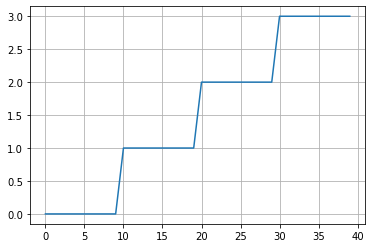

In [113]:
# Data
K = 4
N = K * 10
D = 1
x = np.arange(N)[:,np.newaxis].repeat(D,-1)
y = np.concatenate([np.ones(int(N/K)) * i for i in range(K)], axis = 0)[:,np.newaxis]
r = y - y.mean()
plt.plot(x,y);
plt.grid()

print(x.shape)
print(y.shape)

[1.25,
 1.0125000000000002,
 0.8201250000000002,
 0.6643012500000001,
 0.5380840125,
 0.435848050125,
 0.3530369206012501,
 0.2859599056870127,
 0.2316275236064802,
 0.18761829412124903]

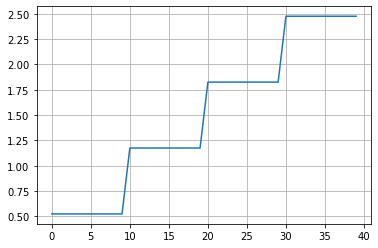

In [116]:
# model
model = XGBoostRegression(num_trees=10, max_depth=4, learning_rate=0.1, lampda=0, gamma=0)
model.fit(x,y)
plt.plot(model.predict(x))
plt.grid()
model.loss